# Spam Comments Detection

The proﬁtability promoted by Google in its brandnew video distribution platform YouTube has attracted anincreasing number of users. However, such success has alsoattracted malicious users, which aim to self-promote their videosor disseminate viruses and malwares. Since YouTube offerslimited tools for comment moderation, the spam volume isshockingly increasing which lead owners of famous channels todisable the comments section in their videos. Automatic commentspam ﬁltering on YouTube is a challenge even for established classiﬁcation methods, since the messages are very short andoften rife with slangs, symbols and abbreviations. In this work, wehave evaluated several top-performance classiﬁcation techniquesfor such purpose. 

We have collected and created five databases composed of real, public, and non-encoded data directly extracted from YouTube through its API in the first semester of 2015. We have selected five of the ten most viewed YouTube videos during the collection period.

In [26]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix

file_path = r'D:\Download\archive\youtube-spam-collection-v1'
data_1 = pd.read_csv(file_path + '\Youtube01-Psy.csv')
data_2 = pd.read_csv(file_path + '\Youtube02-KatyPerry.csv')
data_3 = pd.read_csv(file_path + '\Youtube03-LMFAO.csv')
data_4 = pd.read_csv(file_path + '\Youtube04-Eminem.csv')
data_5 = pd.read_csv(file_path + '\Youtube05-Shakira.csv')


print(data_1.shape)
print(data_2.shape)
print(data_3.shape)
print(data_4.shape)
print(data_5.shape)

# Combination data
data_total = pd.DataFrame()
data_total = pd.concat([data_1,data_2,data_3,data_4,data_5])
print(data_total.shape)



(350, 5)
(350, 5)
(438, 5)
(448, 5)
(370, 5)
(1956, 5)


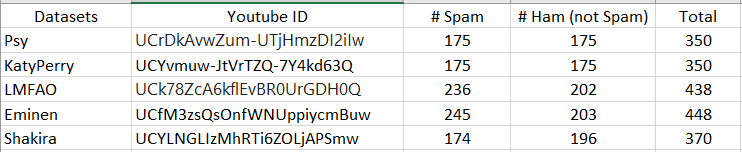

For the experiments, we have ﬁrst processed the datasets,in which, only the texts of comments were used , discarding associated metadata . We employed the bag-of-words modeland frequency representation, as described below.

In [2]:
# use data 1 first
# data_1_ext = data_1[['CONTENT','CLASS']]

#Use all data
data_1_ext = data_total[['CONTENT','CLASS']]
print(data_1_ext.shape)
# Content data
X_data = data_1_ext.iloc[:,0].values
print(X_data[:10])
y_data = data_1_ext.iloc[:,1]


(1956, 2)
['Huh, anyway check out this you[tube] channel: kobyoshi02'
 "Hey guys check out my new channel and our first vid THIS IS US THE  MONKEYS!!! I'm the monkey in the white shirt,please leave a like comment  and please subscribe!!!!"
 'just for test I have to say murdev.com'
 'me shaking my sexy ass on my channel enjoy ^_^ \ufeff'
 'watch?v=vtaRGgvGtWQ   Check this out .\ufeff'
 'Hey, check out my new website!! This site is about kids stuff. kidsmediausa  . com'
 'Subscribe to my channel \ufeff'
 'i turned it on mute as soon is i came on i just wanted to check the  views...\ufeff'
 'You should check my channel for Funny VIDEOS!!\ufeff'
 'and u should.d check my channel and tell me what I should do next!\ufeff']


## Build model

- First build a vocabulary to make a bag of words
- Convert text data to binary value

In [17]:
def preprocess_data(text_data):
# make a set vocal:
    vocab = set()
    for sentence in text_data:
        # Lower all text data
        words = sentence.lower().split()
        vocab.update(words)
    # return to list
    # Add some specific data
    vocab = sorted(list(vocab))

    # Binary encoding 
    encode_matrix = np.zeros((len(text_data), len(vocab)))

    for i,value in enumerate(text_data):
        words = value.lower().split()
        for j,word in enumerate(vocab):
            encode_matrix[i,j] = int(word in words) # Return True(1) or False(0)

    return encode_matrix



[0. 0. 0. ... 0. 0. 0.]


In [20]:
X_data_encoded = preprocess_data(X_data)
print(f'{np.unique(X_data_encoded[1])}')

[0. 1.]


- Let preprocess data

#### Batch generator

In [115]:
def batch_generator(X, y, batch_size=128, shuffle=True):
    """
    Just generate batches of data.

    Parameters has:
    - X: Input features (numpy array or pandas DataFrame)- Your training data
    - y: Target labels (numpy array or pandas Series) - Your target data(or training)
    - batch_size: Size of each batch (default: 32)
    - shuffle: Whether to shuffle the data before batching (default: True)- Random 
    data

    Yields:
    - Tuple of (batch_X, batch_y) representing a batch of features and labels
    """
    num_samples = X.shape[0]
    indices = np.arange(num_samples)

    if shuffle:
        np.random.shuffle(indices)

    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_indices = indices[start_idx:end_idx]
        batch_X = X[batch_indices]
        batch_y = y[batch_indices]
        yield batch_X, batch_y

## Class Bernoulli Naive Bayes

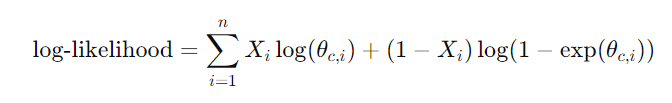

In [13]:
class Bernoulli_Naive_Bayes():
    def __init__(self) -> None:
        self.feature_probabilities = None
        self.class_probabilities = None

    def train(self,X_data,y_data):
        n_samples,n_features = X_data.shape # Number of samples and features
        self.classes = np.unique(y_data) # [0,1]
        n_classes = len(self.classes) # Just number of classes
        # Calculate the class probability P(C)
        self.class_probabilities = np.zeros(n_classes)
        for i, value in enumerate(self.classes):
            self.class_probabilities[i] = np.sum(y_data == value) / n_samples
    
        # Calculate feature probabilities P(C/f)
        self.feature_probabilities = np.zeros((n_classes,n_features)) # 2x1661
        for i,value in enumerate(self.classes):
            class_mask = (y_data == value)
            feature_counts = np.sum(X_data[class_mask],axis=0) # search in row
            # Add laplace smoothing then divide the probability
            self.feature_probabilities[i] = (feature_counts + 1) / (np.sum(class_mask)+2)  # Laplace smoothing

    def predict(self,X_data):
        epsilon = 1e-10
        prob = np.zeros((X_data.shape[0],len(self.classes))) # Probabilities predict
        for i, value in enumerate(self.classes):
            # prevent underflow with low probabilities
            class_probability = np.log(self.class_probabilities[i]+epsilon)
            feature_probability = np.log(self.feature_probabilities[i]+epsilon)
            prob[:, i] = class_probability + np.sum(X_data * feature_probability + (1 - X_data) * np.log(1 - np.exp(feature_probability)), axis=1)    
        print(prob[:10])
        return self.classes[np.argmax(prob,axis=1)] # Return the class has highest probability
     
    




## Test time

In [15]:


model = Bernoulli_Naive_Bayes()

train = model.train(X_train,y_train)




In [16]:
predictions = model.predict(X_test)

# # print(predictions[:100])
# print(y_test[:100])
# print(classification_report(predictions,y_test))

[[ -31.48475182  -43.55233287]
 [ -32.77002661  -46.17842626]
 [ -40.92184392  -50.22436573]
 [-379.70358042 -334.43133062]
 [ -38.08627665  -48.26574685]
 [ -21.21595728  -32.8361468 ]
 [ -64.11714082  -56.42593453]
 [ -48.3489397   -46.17597455]
 [ -25.99067148  -37.88131935]
 [ -76.6456233   -70.56949086]]


### Split data

In [22]:

print(X_train.shape)

(1564, 6094)


In [23]:


train = model.train(X_train,y_train)

predictions = model.predict(X_test)
print(predictions[:100])
print(y_test[:100])
print(classification_report(predictions,y_test))


[0 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1
 0 0 0 0 1 0 1 1 0 1 1 0 0 1 0 1 1 0 0 1 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 1 0
 1 0 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 1]
[0 0 1 1 1 0 1 1 0 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 1
 1 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 0
 1 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1]
              precision    recall  f1-score   support

           0       0.98      0.74      0.85       231
           1       0.73      0.98      0.83       161

    accuracy                           0.84       392
   macro avg       0.85      0.86      0.84       392
weighted avg       0.87      0.84      0.84       392



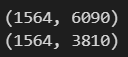

In [31]:

from sklearn.naive_bayes import BernoulliNB, MultinomialNB

X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,
                                                 test_size=0.2,random_state=42)
vect = TfidfVectorizer(use_idf=True,lowercase=True,ngram_range=(1, 2), binary=True)
X_train_2 = vect.fit_transform(X_train)
X_test_2 = vect.transform(X_test)

print(X_train_2.shape)
model2 = MultinomialNB()
model2.fit(X_train_2,y_train)



(1564, 16355)


MultinomialNB()

### Multinomial NB

[0 0 1 1 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1
 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0
 1 0 1 0 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1]
[0 0 1 1 1 0 1 1 0 1 1 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 1
 1 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 0
 1 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 0 1 0 0 1]
              precision    recall  f1-score   support

           0       0.89      0.95      0.91       165
           1       0.96      0.91      0.93       227

    accuracy                           0.93       392
   macro avg       0.92      0.93      0.92       392
weighted avg       0.93      0.93      0.93       392



<Axes: >

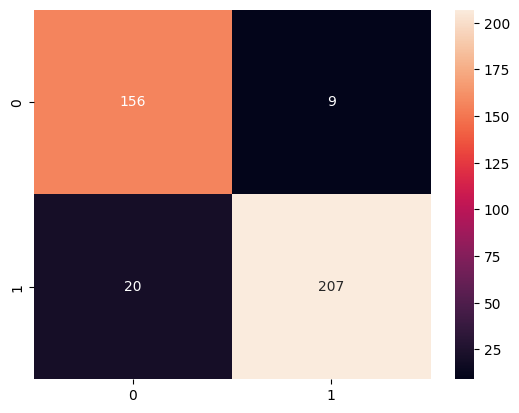

In [32]:


predictions_2 = model2.predict(X_test_2)
print(predictions_2[:100])
print(y_test[:100].values)
print(classification_report(predictions_2,y_test))
cm = confusion_matrix(predictions_2,y_test)
sns.heatmap(data = cm,annot=True,fmt= 'd')

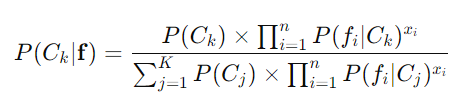

In [36]:
class Multinomial_Naive_Bayes():
    def __init__(self) -> None:
        self.class_probabilities = None #P(C)
        self.feature_probabilities = None #P(f|C)
        self.classes = None
        self.vocab = None

    def preprocess_data(self, data):
        # Create a TF-IDF vectorizer with n-grams and binary=True
        self.vectorizer = TfidfVectorizer(use_idf=True,lowercase=True, ngram_range=(1, 2), binary=True)
        # Fit the vectorizer to the data and transform the data
        X = self.vectorizer.fit_transform(data)
        X_binary = (X != 0).astype(int)
        # Store the vocabulary
        self.vocab = self.vectorizer.get_feature_names_out()
        return X.toarray()
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        n_classes = len(self.classes)

        # Calculate class probabilities
        self.class_probabilities = np.zeros(n_classes)
        for i, c in enumerate(self.classes):
            self.class_probabilities[i] = np.sum(y == c) / n_samples # P(C)

        # Calculate feature probabilities
        self.feature_probabilities = np.zeros((n_classes, n_features))
        for i, c in enumerate(self.classes):
            class_mask = (y == c) # Sample belong the class c (Boolean)
            # Sums the occurrences of each feature (word) across the documents belonging to class c
            class_word_counts = X[class_mask].sum(axis=0) 
            # Calculates the total count of all features in class c
            total_word_counts = class_word_counts.sum()
            
            self.feature_probabilities[i] = (class_word_counts + 1) / (total_word_counts 
                                                                       + n_features) # Add smoothing
    
    def predict(self, X):
        # Calculate log likelihoods for each class
        log_likelihoods = np.dot(X, np.log(self.feature_probabilities.T))
        log_likelihoods += np.log(self.class_probabilities)
        
        # Make predictions
        predictions = np.argmax(log_likelihoods, axis=1)
        return predictions
    
    pass

In [37]:
model_2 = Multinomial_Naive_Bayes()
X_data_encoded = model_2.preprocess_data(X_data)
X_train,X_test,y_train,y_test = train_test_split(X_data_encoded,y_data,
                                                 test_size=0.2,random_state=42)

train = model_2.fit(X_train,y_train)
predict = model_2.predict(X_test)

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       178
           1       0.93      0.93      0.93       214

    accuracy                           0.92       392
   macro avg       0.92      0.92      0.92       392
weighted avg       0.92      0.92      0.92       392



<Axes: >

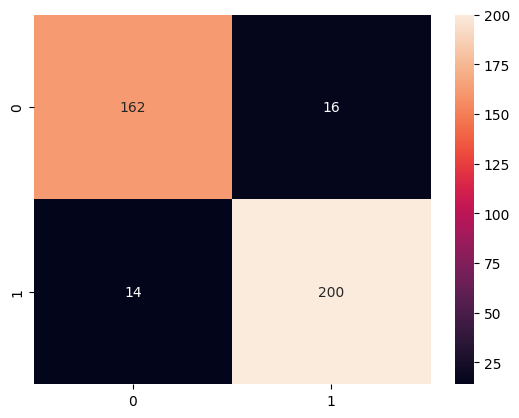

In [38]:
print(classification_report(predict,y_test))
cm = confusion_matrix(predict,y_test)
sns.heatmap(data = cm,annot=True,fmt= 'd')

## Test a comment

In [ ]:
test_comment1 = "i don't know why this is a ham comment"

# Preprocess the test comment
vocab = model_2.vocab
test_comment1_encoded = np.zeros(len(vocab))
test_words = test_comment1.lower().split()
for word in test_words:
    if word in vocab:
        index = np.where(vocab == word)[0][0]  # Find the index of the word in the vocab
        test_comment1_encoded[index] = 1
      
# Reshape the test comment to match the expected input shape  
test_comment1_encoded = test_comment1_encoded.reshape(1, -1)

print(model_2.predict(test_comment1_encoded))


In [ ]:
comment2 = "do u wanna rent 1000000$? yes? check this https://www.youtube.com/watch?v=fHI8X4OXluQ"

test_comment2_encoded = np.zeros(len(vocab))
test_words = comment2.lower().split()
for word in test_words:
    if word in vocab:
        index = np.where(vocab == word)[0][0]  # Find the index of the word in the vocab
        test_comment2_encoded[index] = 1

test_comment2_encoded = test_comment2_encoded.reshape(1, -1)
print(model_2.predict(test_comment2_encoded))